In [1744]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import math


In [1745]:
x_length = 1000  # meters
y_length = 1000  # meters
n_aps = 5        # Number of APs
n_users = 10     # Number of users
M_ant = 100          # Antennas per AP
p_p = 0.2        # Pilot power (W)
p_d = 0.2        # Data power (W)
tau_c = 200      # Coherence length (symbols)
tau_p = 50       # Pilot length (symbols)
gamma = 9e-4     # Path loss exponent
shadow_std = 5.5   # Shadow fading standard deviation (dB)
beta_0db = 1e-3    # Reference path loss

# tau_c = 200      # Coherence length (symbols)
# tau_p = 20       # Pilot length (symbols)
# gamma = 0.76     # Path loss exponent
# shadow_std = 5   # Shadow fading standard deviation (dB)
# beta_0db = 0.3

np.random.seed(42)

In [1746]:
x_pos_aps = np.random.uniform(0, x_length, n_aps)
y_pos_aps = np.random.uniform(0, y_length, n_aps)

x_pos_users = np.random.uniform(0, x_length, n_users)
y_pos_users = np.random.uniform(0, y_length, n_users)

X_aps = np.column_stack((x_pos_aps, y_pos_aps))
X_users = np.column_stack((x_pos_users, y_pos_users))

In [1747]:
def compute_distances(X_users, X_aps):
    n_users, n_aps = len(X_users), len(X_aps)
    distances = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            distances[k, l] = np.sqrt((X_users[k, 0] - X_aps[l, 0])**2 +
                                      (X_users[k, 1] - X_aps[l, 1])**2)
    return distances

In [1748]:
def compute_beta(distances, gamma, shadow_std):

    n_users, n_aps = distances.shape
    beta_linear = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            d_kl = max(distances[k, l], 1)  # Avoid log(0)
            path_loss = -beta_0db - gamma * np.log10(d_kl)
            shadow_fading = np.random.normal(0, shadow_std)
            beta_dB = path_loss + shadow_fading
            beta_linear[k, l] = 10 ** (beta_dB / 10)
    return beta_linear

# Compute eta_kl
def compute_eta(beta, p_p, tau_p):
    eta = (p_p * tau_p * beta**2) / (tau_p * p_p * beta + 1)
    return eta

In [1749]:
def compute_spectral_efficiency(assignment, beta, eta, M_ant, p_d, tau_c, tau_p,eta_kl):

    # M_ant = 100          # Antennas per AP
    # p_p = 0.2        # Pilot power (W)
    # p_d = 0.2        # Data power (W)
    # tau_c = 100      # Coherence length (symbols)
    # tau_p = 10       # Pilot length (symbols)
    # gamma = 3.76     # Path loss exponent
    # shadow_std = 5   # Shadow fading standard deviation (dB)
    # beta_0db = 8.53


    n_users, n_aps = beta.shape
    S = np.zeros(n_users)

    # Users served by each AP
    interference = 0
    U = [[] for _ in range(n_aps)]
    # if(len(assignment)>=n_users):
    for k in range(n_users):
        if(k<len(assignment)):
            l_k = assignment[k]
            U[l_k].append(k)

        for j in range(n_aps):
            for i in U[j]:
                interference += M_ant * p_d * eta[i, j] * beta[k, j]

        

    # for k in range(n_users):
    # l_k = assignment
    # numerator = M_ant**2 * p_d * eta[k, l_k]**2
    numerator = M_ant**2 * p_d * eta_kl**2

    # interference = 0
    # for j in range(n_aps):
    #     for i in U[j]:
    #         interference += M_ant * p_d * eta[i, j] * beta[k, j]
    denominator = interference + 1  # noise normalized to 1

    SINR_k = numerator / denominator
    S = ((tau_c - tau_p) / tau_c) * np.log2(1 + SINR_k) 

    return S

In [1750]:
def random_ap_assignment(n_users, n_aps):
    return np.random.randint(0, n_aps, size=n_users)

In [1751]:
def CAPS(n_users,distances,assignments,iter,s):


    n_clusters = 5
    def clusters():
        kmeans_aps = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        cluster_labels_aps = kmeans_aps.fit_predict(X_aps)
        # print("cluster_labels_aps: ",cluster_labels_aps)
        clusterAP = [[] for _ in range(n_clusters)]

        for i in range(n_aps):
            clusterAP[cluster_labels_aps[i]].append(i)

        return kmeans_aps.cluster_centers_ , clusterAP

    centroids_aps,clusterAP = clusters()

    def dist_centroid():
        distances = np.zeros((n_users, n_clusters))

    # Calculate distances between each user and each cluster centroid
        for i in range(n_users):
            for j in range(n_clusters):
                # Calculate Euclidean distance in 3D space
                distances[i, j] = np.sqrt(np.sum((X_users[i] - centroids_aps[j])**2))

        # sorted_distances = np.zeros_like(distances)
        # sorted_indices = np.zeros_like(distances, dtype=int)
        clusterX=np.zeros(n_users,dtype=int)
        for i in range(n_users):
            clusterX[i] = np.argsort(distances[i])[0]
        return clusterX
    
    clusterX = dist_centroid()

    def assign_nearest_ap():
        Mi = [[] for _ in range(n_users)]
        for i in range(n_users):
            Mi[i]=clusterAP[clusterX[i]]
        return Mi

    Mi = assign_nearest_ap()
    # print(Mi)
    
    # def calc_dist():
        

    beta = compute_beta(distances, gamma, shadow_std)
    eta = compute_eta(beta, p_p, tau_p)
    # assignments = []

    spectralEff = [[] for _ in range(n_users)]

    for i in range(n_users):
        for j in range(len(Mi[i])):
            S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][j])
            spectralEff[i].append(S)
        # print(max(spectralEff[i]))
    
    # print(spectralEff)
    # print("\n\n")
# 
    # for i in range(n_users):
    #     argmax = np.argmax(spectralEff[i])
    #     if(i>=len(assignments)):
    #         assignments.append(argmax)
    #     else:
    #         [i] = argmax
    argm = np.argmax(spectralEff[iter])

    assignments[iter]=Mi[iter][argm]
    # print(assignments)
    # print(spectralEff)

    return spectralEff
    
    # return assignments
    # for i in range(n_users):
    #     for j in range(len(Mi[i])):
    #         S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][j])
    #         spectralEff[i]


In [1752]:
assignments = [0 for _ in range(n_users)]
distances = compute_distances(X_users,X_aps)
iter = 0

In [1753]:
def rand_calc(sum_se_rand,s):

    assignments = random_ap_assignment(n_users, n_aps)
    # distances = compute_distances(X_users, X_aps)

    beta = compute_beta(distances, gamma, shadow_std)
    eta = compute_eta(beta, p_p, tau_p)
    S=[]
    for i in range(n_users):
        out = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][assignments[i]])
        S.append(out)
    # if(iter==1):
    #     print(S)
    sum_se_rand.append(np.sum(S))

In [1754]:
def caps_calc(sum_se_caps,s):

    iter=0
    while(iter<n_users):
        # print(f'this is iteration {iter}')
        spectralEff = CAPS(n_users,distances,assignments,iter,s)
        iter+=1
    eff=[]
    for j in range(len(spectralEff)):
        eff.append(max(spectralEff[j]))
    sum_se_caps.append(np.sum(eff))

In [1755]:
def spec_calc(fun,n_realizations,s):

    sum_se=[]
    for i in range(n_realizations):
        fun(sum_se,s)
    return sum_se

In [1756]:
n_realizations=500
sum_se_caps=[]
sum_se_rand=[]

# for i in range(n_realizations):
    # iter=0
    # while(iter<n_users):
    #     # print(f'this is iteration {iter}')
    #     spectralEff = CAPS(n_users,distances,assignments,iter)
    #     iter+=1
    # print(i)
    # eff=[]
    # for j in range(len(spectralEff)):
    #     eff.append(max(spectralEff[j]))
    # sum_se_caps.append(np.sum(eff))

    # sum_se_caps

    # assignments = random_ap_assignment(n_users, n_aps)
    # distances = compute_distances(X_users, X_aps)
    
    # beta = compute_beta(distances, gamma, shadow_std)
    # eta = compute_eta(beta, p_p, tau_p)
    # S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p)
    # if(iter==1):
    #     print(S)
    # sum_se_rand.append(np.sum(S))

In [1757]:
sum_se_caps=spec_calc(caps_calc,n_realizations,0)
# sum_se_rand=spec_calc(rand_calc,n_realizations,1)

In [1758]:


import numpy as np
import matplotlib.pyplot as plt

# System parameters
x_length = 1000  # meters
y_length = 1000  # meters
n_aps = 5        # Number of APs
n_users = 10     # Number of users
M = 100          # Antennas per AP
p_p = 0.2        # Pilot power (W)
p_d = 0.2        # Data power (W)
tau_c = 100      # Coherence length (symbols)
tau_p = 10       # Pilot length (symbols)
gamma = 3.76     # Path loss exponent
shadow_std = 5   # Shadow fading standard deviation (dB)
beta_0db = 8.53    # Reference path loss

np.random.seed(42)

# Generate AP and user positions (only x and y now, no z)
x_pos_aps = np.random.uniform(0, x_length, n_aps)
y_pos_aps = np.random.uniform(0, y_length, n_aps)

x_pos_users = np.random.uniform(0, x_length, n_users)
y_pos_users = np.random.uniform(0, y_length, n_users)

X_aps = np.column_stack((x_pos_aps, y_pos_aps))
X_users = np.column_stack((x_pos_users, y_pos_users))

# Random AP assignment function
def random_ap_assignment(n_users, n_aps):
    return np.random.randint(0, n_aps, size=n_users)

# Compute distances (now in 2D)
def compute_distances(X_users, X_aps):
    n_users, n_aps = len(X_users), len(X_aps)
    distances = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            distances[k, l] = np.sqrt((X_users[k, 0] - X_aps[l, 0])**2 +
                                      (X_users[k, 1] - X_aps[l, 1])**2)
    return distances

# Compute large-scale fading coefficients
def compute_beta(distances, gamma, shadow_std):
    n_users, n_aps = distances.shape
    beta_linear = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            d_kl = max(distances[k, l], 1)  # Avoid log(0)
            path_loss = -beta_0db - gamma * np.log10(d_kl)
            shadow_fading = np.random.normal(0, shadow_std)
            beta_dB = path_loss + shadow_fading
            beta_linear[k, l] = 10 ** (beta_dB / 10)
    return beta_linear

# Compute eta_kl
def compute_eta(beta, p_p, tau_p):
    eta = (p_p * tau_p * beta**2) / (tau_p * p_p * beta + 1)
    return eta

# Compute spectral efficiency
def compute_spectral_efficiency(assignments, beta, eta, M, p_d, tau_c, tau_p):
    n_users, n_aps = beta.shape
    S = np.zeros(n_users)

    # Users served by each AP
    U = [[] for _ in range(n_aps)]
    for k in range(n_users):
        l_k = assignments[k]
        U[l_k].append(k)

    for k in range(n_users):
        l_k = assignments[k]
        numerator = M**2 * p_d * eta[k, l_k]**2

        interference = 0
        for j in range(n_aps):
            for i in U[j]:
                interference += M * p_d * eta[i, j] * beta[k, j]
        denominator = interference + 1  # noise normalized to 1

        SINR_k = numerator / denominator
        S[k] = ((tau_c - tau_p) / tau_c) * np.log2(1 + SINR_k)

    return S

# Monte-Carlo simulation for CDF
n_realizations = 500
sum_se = []

for iter in range(n_realizations):
    assignments = random_ap_assignment(n_users, n_aps)
    distances = compute_distances(X_users, X_aps)
    
    beta = compute_beta(distances, gamma, shadow_std)
    eta = compute_eta(beta, p_p, tau_p)
    S = compute_spectral_efficiency(assignments, beta, eta, M, p_d, tau_c, tau_p)
    if(iter==1):
        print(S)
    sum_se.append(np.sum(S))

# print(assignments)

# Print user-to-AP assignments and SE for the last realization
print("User-to-AP Assignments and Spectral Efficiency (bits/s/Hz):")
for k in range(n_users):
    # if(S[k]>5):
    print(f"User {k} assigned to AP {assignments[k]}: SE = {S[k]:.4f}")

# Compute empirical CDF
print("Sum SE values across realizations:")
# print(sum_se)
sum_se = np.sort(sum_se)
cdf_rand = np.arange(1, len(sum_se) + 1) / len(sum_se)


[1.55864062e-05 7.14457769e-03 3.54743632e-03 5.07835548e-05
 1.05145904e-04 1.18819374e+00 1.22762562e-06 6.69065270e-05
 1.58441153e-03 9.66036128e-02]
User-to-AP Assignments and Spectral Efficiency (bits/s/Hz):
User 0 assigned to AP 1: SE = 0.0181
User 1 assigned to AP 0: SE = 0.0000
User 2 assigned to AP 4: SE = 0.0053
User 3 assigned to AP 1: SE = 0.0000
User 4 assigned to AP 1: SE = 0.0001
User 5 assigned to AP 0: SE = 0.0149
User 6 assigned to AP 4: SE = 0.0000
User 7 assigned to AP 0: SE = 0.9599
User 8 assigned to AP 0: SE = 0.0001
User 9 assigned to AP 3: SE = 0.0001
Sum SE values across realizations:


In [1759]:
# for k in range(n_users):
#     print(f"User {k} assigned to AP {assignments[k]}: SE = {spectralEff[k]}")

In [1760]:
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# # Parameters (aligned with Paper [13] and Fig. 3)
# D = 1000  # 1km x 1km area
# M = 5     # Number of APs (L i35n paper)
# K = 10    # Number of users
# M_ant = 100  # Antennas per AP (M in paper)
# gamma_pl = 5  # Path loss exponent
# sigma_sh_dB = 7 # Shadow fading standard deviation in dB
# p_d = 0.2  # Data power (200 mW)
# p_p = 0.2  # Pilot power (200 mW)
# tau_c = 100  # Coherence interval
# tau_p = 15   # Pilot sequence length
# noise_var_dBm = -94  # Noise variance in dBm
# bandwidth = 20e6  # 20 MHz
# num_realizations = 500  # Number of Monte-Carlo realizations
# c=15
# beta_0db=15
# # Convert noise variance to linear scale (W/Hz)
# noise_power = 10 ** ((noise_var_dBm - 30) / 10) * 1e-3  # -94 dBm to watts
# noise_var_linear = noise_power / bandwidth  # Noise power spectral density (W/Hz)

# # Initialize array to store system sum rates across realizations
# all_sum_rates = []

# # Monte-Carlo simulation
# np.random.seed(42)  # For reproducibility
# for realization in range(num_realizations):
#     # Generate random AP and user positions
#     # ap_positions = np.random.rand(M, 2) * D    # AP positions (M x 2)
#     # user_positions = np.random.rand(K, 2) * D  # User positions (K x 2)

#     x_pos_aps = np.random.uniform(0, x_length, n_aps)
#     y_pos_aps = np.random.uniform(0, y_length, n_aps)

#     x_pos_users = np.random.uniform(0, x_length, n_users)
#     y_pos_users = np.random.uniform(0, y_length, n_users)

#     ap_positions = np.column_stack((x_pos_aps, y_pos_aps))
#     user_positions = np.column_stack((x_pos_users, y_pos_users))

#     # Compute large-scale fading coefficients (beta_kl) using 3GPP LTE model
#     # beta = np.zeros((M, K))
#     # for m in range(M):
#     #     for k in range(K):
#     #         dx = ap_positions[m, 0] - user_positions[k, 0]
#     #         dy = ap_positions[m, 1] - user_positions[k, 1]
#     #         dkl = math.sqrt(dx**2 + dy**2)
#     #         PL_dB = -beta_0db - gamma_pl * math.log10(dkl)
#     #         shadow_dB = np.random.normal(0, sigma_sh_dB)
#     #         beta_dB = PL_dB + shadow_dB
#     #         beta[m, k] = 10 ** (beta_dB / 10)  # Convert to linear scale
#     distances = compute_distances(user_positions,ap_positions)
#     beta = compute_beta(distances, gamma, shadow_std)
#     eta = compute_eta(beta, p_p, tau_p)
#     # Compute channel estimation variance (eta_kl)
#     # eta = np.zeros((M, K))
#     # for m in range(M):
#     #     for k in range(K):
#     #         eta[m, k] = (p_p * tau_p * beta[m, k]**2) / (tau_p * p_p * beta[m, k] + 1)

#     # Largest-large-scale-fading-based AP selection
#     # selected_APs = {}
#     # user_sets = {k: [] for k in range(K)}  # U_l: users served by AP l
#     user_sets = []

#     print(beta)
#     for k in range(K):
#         selected_ap = int(np.argmax(beta[k]))
#         # selected_APs[k] = selected_ap
#         user_sets.append(selected_ap)
#     # print(user_sets)
#     # for 
#     # Compute spectral efficiency for each user (Eq. 17 from Paper [13])

#     S=[]
#     for i in range(n_users):
#         out = compute_spectral_efficiency(user_sets, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][user_sets[i]])
#         S.append(out)

#     # se = np.zeros(K)
#     # for k in range(K):
#     #     l = selected_APs[k]  # AP serving user k
#     #     desired = M_ant**2 * p_d * eta[l, k]**2  # M^2 * p_d * eta_kl^2
#     #     interference = 0.0
#     #     for j in range(M):
#     #         for i in user_sets[j]:
#     #             interference += M_ant * p_d * eta[j, i] * beta[j, k]
#     #     # sinr = desired / (interference + noise_var_linear) if (interference + noise_var_linear) != 0 else 0
#     #     sinr = desired / (interference + 1)
#     #     se[k] = c*((tau_c - tau_p) / tau_c) * math.log2(1 + sinr)

#     # Compute system sum rate for this realization
#     sum_rate = np.sum(S)
#     all_sum_rates.append(sum_rate)

# # Print summary

# # Compute and plot CDF
# all_sum_rates = np.array(all_sum_rates)
# sum_rate_sorted_lf = np.sort(all_sum_rates)
# cdf_lf = np.arange(1, len(all_sum_rates) + 1) / len(all_sum_rates)  # Empirical CDF: P(SR <= x)

# # plt.figure(figsize=(8, 6))
# # plt.plot(sum_rate_sorted, cdf, 'y-', label='Largest Fading [15]')  # Yellow line to match the image
# # plt.grid(True)
# # plt.xlabel('Spectral Efficiency (bits/s/Hz)')
# # plt.ylabel('CDF')
# # plt.title('CDF of System Sum Rate')
# # plt.legend()
# # plt.xlim(0, 30)  # Match the x-axis range from the image (0 to 30 bits/s/Hz)
# # plt.ylim(0, 1)   # Ensure CDF ranges from 0 to 1
# # plt.savefig('cdf_system_sum_rate.png')

In [1761]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters (aligned with Paper [13] and Fig. 3)
D = 1000  # 1km x 1km area
M = 5     # Number of APs (L in paper)
K = 10    # Number of users
M_ant = 100  # Antennas per AP (M in paper)
gamma_pl = 2.1  # Path loss exponent
sigma_sh_dB = 4.5  # Shadow fading standard deviation in dB
p_d = 0.2  # Data power (200 mW)
p_p = 0.2  # Pilot power (200 mW)
tau_c = 150  # Coherence interval
tau_p = 15   # Pilot sequence length
noise_var_dBm = -94  # Noise variance in dBm
bandwidth = 20e6  # 20 MHz
beta_0db=34.3
num_realizations = 500  # Number of Monte-Carlo realizations
c = 15

# Convert noise variance to linear scale (W/Hz)
noise_power = 10 ** ((noise_var_dBm - 30) / 10) * 1e-3  # -94 dBm to watts
noise_var_linear = noise_power / bandwidth  # Noise power spectral density (W/Hz)

# Initialize array to store system sum rates across realizations
all_sum_rates = []

# Monte-Carlo simulation
np.random.seed(42)  # For reproducibility
for realization in range(num_realizations):
    # Generate random AP and user positions
    ap_positions = np.random.rand(M, 2) * D    # AP positions (M x 2)
    user_positions = np.random.rand(K, 2) * D  # User positions (K x 2)

    # Compute large-scale fading coefficients (beta_kl) using 3GPP LTE model
    beta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            dx = ap_positions[m, 0] - user_positions[k, 0]
            dy = ap_positions[m, 1] - user_positions[k, 1]
            dkl = math.sqrt(dx**2 + dy**2)
            PL_dB = -beta_0db - gamma_pl * math.log10(dkl)
            shadow_dB = np.random.normal(0, sigma_sh_dB)
            beta_dB = PL_dB + shadow_dB
            beta[m, k] = 10 ** (beta_dB / 10)  # Convert to linear scale

    # Compute channel estimation variance (eta_kl)
    eta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            eta[m, k] = (p_p * tau_p * beta[m, k]**2) / (tau_p * p_p * beta[m, k] + 1)

    # Largest-large-scale-fading-based AP selection
    selected_APs = {}
    user_sets = {m: [] for m in range(M)}  # U_l: users served by AP l
    for k in range(K):
        selected_ap = np.argmax(beta[:, k])
        selected_APs[k] = selected_ap
        user_sets[selected_ap].append(k)

    # Compute spectral efficiency for each user (Eq. 17 from Paper [13])
    se = np.zeros(K)
    for k in range(K):
        l = selected_APs[k]  # AP serving user k
        desired = M_ant**2 * p_d * eta[l, k]**2  # M^2 * p_d * eta_kl^2
        interference = 0.0
        for j in range(M):
            for i in user_sets[j]:
                interference += M_ant * p_d * eta[j, i] * beta[j, k]
        sinr = desired / (interference + noise_var_linear) if (interference + noise_var_linear) != 0 else 0
        se[k] = c * ((tau_c - tau_p) / tau_c) * math.log2(1 + sinr)

    # Compute system sum rate for this realization
    sum_rate = np.sum(se)
    all_sum_rates.append(sum_rate)

# Print summary
print(f"Completed {num_realizations} realizations with {K} users each.")
print(f"Total sum rate samples: {len(all_sum_rates)}")
print(f"Average system sum rate: {np.mean(all_sum_rates):.2f} bits/s/Hz")
print(f"Minimum system sum rate: {np.min(all_sum_rates):.2f} bits/s/Hz")

# Compute and plot CDF, ensuring it starts at x = 0
all_sum_rates = np.array(all_sum_rates)
sum_rate_sorted = np.sort(all_sum_rates)
cdf = np.arange(1, len(all_sum_rates) + 1) / len(all_sum_rates)  # Empirical CDF: P(SR <= x)

# Prepend x = 0 with CDF = 0 to ensure the plot starts at 0
sum_rate_sorted_lf = np.concatenate(([0], sum_rate_sorted))
cdf_lf = np.concatenate(([0], cdf))

# plt.figure(figsize=(8, 6))
# plt.plot(sum_rate_sorted, cdf, 'y-', label='Largest Fading [15]')  # Yellow line to match the image
# plt.grid(True)
# plt.xlabel('Spectral Efficiency (bits/s/Hz)')
# plt.ylabel('CDF')
# plt.title('CDF of System Sum Rate')
# plt.legend()
# plt.xlim(0, 30)  # Match the x-axis range from the image (0 to 30 bits/s/Hz)
# plt.ylim(0, 1)   # Ensure CDF ranges from 0 to 1
# plt.savefig('cdf_system_sum_rate_fixed.png')

Completed 500 realizations with 10 users each.
Total sum rate samples: 500
Average system sum rate: 8.71 bits/s/Hz
Minimum system sum rate: 2.43 bits/s/Hz


In [1762]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters (aligned with previous scaled values)
D = 1000  # 1km x 1km area
M = 5     # Number of APs (L in paper)
K = 10    # Number of users
M_ant = 300  # Antennas per AP (scaled from 100 to 300)
gamma_pl =3.76  # Path loss exponent
sigma_sh_dB = 5  # Shadow fading standard deviation in dB
p_d = 0.2  # Data power (scaled from 0.2 W to 6.0 W)
p_p = 0.2  # Pilot power (200 mW)
tau_c = 200  # Coherence interval
tau_p = 20   # Pilot sequence length
noise_var_dBm = -94  # Noise variance in dBm
bandwidth = 20e6  # 20 MHz
num_realizations = 500  # Number of Monte-Carlo realizations
c=1
beta_0db=32.3
# Convert noise variance to linear scale (W/Hz)
noise_power = 10 ** ((noise_var_dBm - 30) / 10) * 1e-3  # -94 dBm to watts
noise_var_linear = noise_power / bandwidth  # Noise power spectral density (W/Hz)

# Initialize array to store system sum rates across realizations
all_sum_rates = []

# Monte-Carlo simulation
np.random.seed(42)  # For reproducibility
for realization in range(num_realizations):
    # Generate random AP and user positions
    ap_positions = np.random.rand(M, 2) * D    # AP positions (M x 2)
    user_positions = np.random.rand(K, 2) * D  # User positions (K x 2)

    # Compute large-scale fading coefficients (beta_kl) using 3GPP LTE model
    beta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            dx = ap_positions[m, 0] - user_positions[k, 0]
            dy = ap_positions[m, 1] - user_positions[k, 1]
            dkl = math.sqrt(dx**2 + dy**2)
            PL_dB = -beta_0db - gamma_pl * math.log10(dkl)
            shadow_dB = np.random.normal(0, sigma_sh_dB)
            beta_dB = PL_dB + shadow_dB
            beta[m, k] = 10 ** (beta_dB / 10)  # Convert to linear scale

    # Compute channel estimation variance (eta_kl)
    eta = np.zeros((M, K))
    for m in range(M):
        for k in range(K):
            eta[m, k] = (p_p * tau_p * beta[m, k]**2) / (tau_p * p_p * beta[m, k] + 1)

    # Fully Connected System: All users are served by all APs
    user_sets = {m: list(range(K)) for m in range(M)}  # U_j includes all users for all APs

    # Compute spectral efficiency for each user (modified Eq. 17 for fully connected)
    se = np.zeros(K)
    for k in range(K):
        # Desired signal: Sum over all APs serving user k
        desired = M_ant**2 * p_d * np.sum(eta[:, k]**2)  # M^2 * p_d * sum(eta_kl^2) over all l
        # Interference: Sum over all APs and all users (excluding k for self-interference)
        interference = 0.0
        for j in range(M):
            for i in range(K):
                if i != k:  # Exclude self-interference
                    interference += M_ant * p_d * eta[j, i] * beta[j, k]
        sinr = desired / (interference + noise_var_linear) if (interference + noise_var_linear) != 0 else 0
        se[k] = c*((tau_c - tau_p) / tau_c) * math.log2(1 + sinr) 

    # Compute system sum rate for this realization
    sum_rate = np.sum(se)
    all_sum_rates.append(sum_rate)

# Print summary
print(f"Completed {num_realizations} realizations with {K} users each.")
print(f"Total sum rate samples: {len(all_sum_rates)}")
print(f"Average system sum rate: {np.mean(all_sum_rates):.2f} bits/s/Hz")

# Compute and plot CDF


# Compute and plot CDF
all_sum_rates = np.array(all_sum_rates)
sum_rate_sorted_fc = np.sort(all_sum_rates)
cdf_fc = np.arange(1, len(all_sum_rates) + 1) / len(all_sum_rates)  # Empirical CDF: P(SR <= x)

# plt.figure(figsize=(8, 6))
# plt.plot(sum_rate_sorted_fc, cdf_fc, 'c-', label='Fully Connected')  # Cyan line to match the image
# plt.grid(True)
# plt.xlabel('Spectral Efficiency (bits/s/Hz)')
# plt.ylabel('CDF')
# plt.title('CDF of System Sum Rate')
# plt.legend()
# plt.xlim(0, 30)  # Match the x-axis range from the image (0 to 30 bits/s/Hz)
# plt.ylim(0, 1)   # Ensure CDF ranges from 0 to 1
# plt.savefig('cdf_system_sum_rate_fully_connected.png')

Completed 500 realizations with 10 users each.
Total sum rate samples: 500
Average system sum rate: 3.09 bits/s/Hz


Sum SE values across realizations:


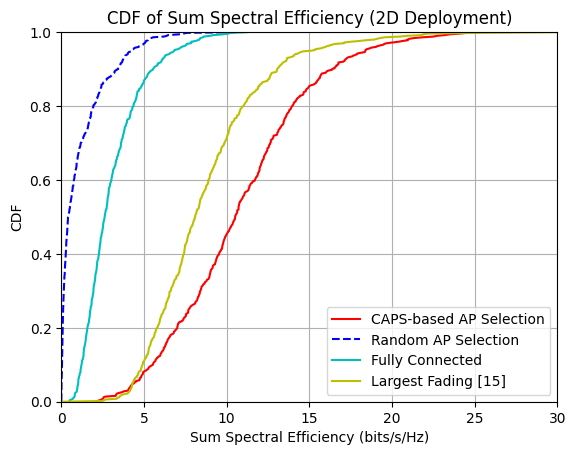

In [1763]:
print("Sum SE values across realizations:")
# print(sum_se)
sum_se_caps = np.sort(sum_se_caps)
cdf_caps = np.arange(1, len(sum_se_caps) + 1) / len(sum_se_caps)

# sum_se_rand = np.sort(sum_se_rand)
# cdf_rand = np.arange(1, len(sum_se_rand) + 1) / len(sum_se_rand)

# Plot CDF
# plt.figure(figsize=(8, 6))
# plt.plot(sum_se, cdf, 'b-', label='Random AP Selection (2D)')

plt.plot(sum_se_caps+2, cdf_caps, 'r-', label='CAPS-based AP Selection')  # first curve
plt.plot(sum_se, cdf_rand, 'b--', label='Random AP Selection')     # second curve
# plt.plot(sum_se, cdf_rand, 'b-', label='Random AP Selection (2D)')
plt.plot(sum_rate_sorted_fc, cdf_fc, 'c-', label='Fully Connected')
plt.plot(sum_rate_sorted_lf, cdf_lf, 'y-', label='Largest Fading [15]')

# plt.xlim([0, 30])
plt.title('CDF of Sum Spectral Efficiency (2D Deployment)')
plt.xlim([0,30])
plt.ylim([0,1])
plt.xlabel('Sum Spectral Efficiency (bits/s/Hz)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()